In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import os
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
import re
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from nltk.tokenize import word_tokenize
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import random
from sklearn.metrics.pairwise import euclidean_distances
from tqdm import tqdm

In [2]:
data = pd.read_csv('genre_filtered_movie_no_entities.csv')
data

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,cast,info_json,movie_id,...,Drama,Horror,Family,War,Animation,Biography,Action,Fantasy,summary_no_names,cast_len
0,0,0,0,0,0,0,0,"[{'nm0000209': [' Tim Robbins']}, {'nm0327779'...","{'Title': 'War of the Worlds', 'Year': '2005',...",War of the Worlds,...,0,0,0,0,0,0,0,0,Divorced longshoreman Ray Ferrier works at a d...,15
1,1,1,1,1,1,1,1,"[{'nm0914612': [' Emma Watson']}, {'nm0341743'...",{'Title': 'Harry Potter and the Deathly Hallow...,Harry Potter and the Deathly Hallows: Part 1,...,0,0,1,0,0,0,0,1,The Minister of Magic Rufus addresses the wiza...,15
2,2,2,2,2,2,2,2,"[{'nm0043173': [' Rick Aviles']}, {'nm0534398'...","{'Title': 'The Stand', 'Year': '1994', 'Rated'...",The Stand,...,1,1,0,0,0,0,0,1,"On June 13 , at a top - secret government labo...",32
3,3,3,3,3,3,3,3,"[{'nm0000295': [' Kate Beckinsale']}, {'nm0640...","{'Title': 'Van Helsing', 'Year': '2004', 'Rate...",Van Helsing,...,0,0,0,0,0,0,1,1,Monster hunter Gabriel Van Helsing and friar C...,15
4,4,4,4,4,4,5,5,"[{'nm0000349': [' Joan Cusack']}, {'nm0000885'...","{'Title': 'Toy Story 3', 'Year': '2010', 'Rate...",Toy Story 3,...,0,0,1,0,1,0,0,1,Andy is preparing to leave for college . He ha...,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4656,4659,4659,4659,4664,4947,5955,1833,"[{'nm0528695': [' Jack Lynn']}, {'nm0377931': ...","{'Title': 'Yentl', 'Year': '1983', 'Rated': 'P...",Yentl,...,1,0,0,0,0,0,0,0,"Barbra Streisand portrays Mendel , a girl livi...",15
4657,4660,4660,4660,4665,4950,5958,1836,"[{'nm0662116': [' Cecil Parker']}, {'nm0665327...","{'Title': 'The Court Jester', 'Year': '1955', ...",The Court Jester,...,0,0,1,0,0,0,0,0,"Set in medieval , the plot concerns the strugg...",15
4658,4661,4661,4661,4666,4951,5959,1839,"[{'nm1869008': [' Anya Engel-Adams']}, {'nm000...","{'Title': 'Chi-Raq', 'Year': '2015', 'Rated': ...",Chi-Raq,...,1,0,0,0,0,0,0,0,"In 's , as the events are narrated by , a war ...",15
4659,4662,4662,4662,4667,4952,5960,1840,"[{'nm0082848': [' Bindu']}, {'nm2061852': [' A...","{'Title': 'Om Shanti Om', 'Year': '2007', 'Rat...",Om Shanti Om,...,1,0,0,0,0,0,1,0,"In , Om Prakash Makhija , a junior artist in ...",15


In [3]:
# removing nan items
nan_items = []
for i,d in data.iterrows():
    if type(d['summary_wiki'])!= str:
        nan_items.append(i)
data = data.drop(nan_items)

# removing 0 cast movies
data['cast']= [eval(c) for c in data['cast']]
data['cast_len'] = [len(c) for c in data['cast']]
data = data.drop(data[data['cast_len']==0].index)

In [4]:
# Removing names
nlp = spacy.load('en_core_web_sm')
stop_words = stopwords.words("english")

#filter out names through nerc
def remove_names(text):
    document = nlp(text)
    ents = [e.text for e in document.ents if e.label_ != 'PERSON']
    return " ".join([item.text for item in document if item.text not in ents])

#data['summary_no_names'] = data['summary_wiki'].apply(lambda x: remove_names(x))
#data.to_csv('genre_filtered_movie_no_entities.csv')

In [5]:
# sampling
genres = ['Animation', 'Family', 'Fantasy', 'Mystery',
       'Sci-Fi', 'Thriller', 'Biography', 'Musical', 'War', 'Western',
       'Adventure', 'Horror', 'Drama', 'Romance', 'Action', 'Crime', 'Comedy',
       'History']

sample_movie_indexes = []
for g in genres:
    for i,m in data[data[g]==1].sample(2).iterrows():
        sample_movie_indexes.append(i)

        
data_len = len(data)

sample_percentage = 10
sample_movie_indexes = random.sample(range(data_len), int(data_len/sample_percentage))

train_index = [x for x in range(len(data)) if x not in sample_movie_indexes]

test_df = data.iloc[sample_movie_indexes, :].reset_index()
train_df = data.iloc[train_index,:].reset_index()

In [6]:
for i,d in data.iterrows():
    if len(data['cast']) ==0:
        print('fudeu', i , data['cast'])

In [7]:
# tokenizer
stemmer = WordNetLemmatizer()
def tokenize(content):
    letters_only = re.sub("[^a-zA-Z]"," ", content)
    lower_case = letters_only.lower()
    tokens = word_tokenize(lower_case)
    words = [w for w in tokens if not w in stop_words]
    stems = [stemmer.lemmatize(word) for word in words]
    return(stems)

In [8]:
def print_topics(topics, feature_names, sorting, topics_per_chunk=6, n_words=20):
    for i in range(0, len(topics), topics_per_chunk):
        these_topics = topics[i: i + topics_per_chunk]
        len_this_chunk = len(these_topics)
        words = []
        for i in range(n_words):
            try:
                words.append(feature_names[sorting[these_topics, i]])
            except:
                pass

    #setting up word dictionary for comparison
    word_dict = {}
    for i in topics:
        word_dict.update({i : [word[i] for word in words]})
    
    return word_dict


In [9]:
def topic_report(file, df, topics, feature_names, sorting):
    
    file.write('TOPICS REPORT \n')
    lda_topics = print_topics(topics=range(topics), feature_names=feature_names, sorting=sorting, topics_per_chunk=topics)

    for i in range(topics):
        file.write('---------------- \n')
        file.write('TOPIC : '+str(i)+ '\n')
        file.write('MOST IMPORTANT WORDS: '+str(lda_topics[i])+'\n')
        file.write('MOVIES OF THIS TOPIC: \n')
        for i,m in df[df['clusters'] == i].iterrows():
            file.write(m['movie_id']+"\n")
    

In [10]:
def topic_word_cloud(lda_model,feature_names, topic):
    
    word_matrix = lda_model.components_[topic]
    word_dict = dict(zip(feature_names, word_matrix))
    wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(word_dict)
    
    return wc

In [11]:
#def get_list_of_actors_clustering(lda_model, document_topics, word_vectorizer, text):
def get_list_of_actors_clustering(lda_model, document_topics, feature_vector):
    #feature_vector = word_vectorizer.transform([text])
    topic_distribution = lda_model.transform(feature_vector)
    topic = topic_distribution[0].argmax()
    related_documents = []
    clusters = np.argmax(document_topics, axis = 1)
    for i, e in enumerate(clusters):
        if e == topic:
            related_documents.append(i)
    return (topic, related_documents)
    

In [12]:
#def baseline(document_topics, word_vectorizer, text, k = 10):
def baseline(document_topics,feature_vector, k = 10):
    #feature_vector = word_vectorizer.transform([text]).toarray()[0]
    distances = []
    for document in document_topics.toarray():
        distances.append(euclidean(feature_vector, document))
    
    return np.argsort(np.array(distances))[0:k]

In [13]:
#def get_list_of_k_nearest_documents(lda_model, document_topics, word_vectorizer, text, k = 10):
def get_list_of_k_nearest_documents(lda_model, document_topics,feature_vector , k = 10):
    #feature_vector = word_vectorizer.transform([text])
    topic_distribution = lda_model.transform(feature_vector)[0]
    distances = []
    for document in document_topics:
        distances.append(euclidean(topic_distribution, document))
    
    return np.argsort(np.array(distances))[0:k]

In [14]:
cast = list(train_df['cast'])
test_cast = list(test_df['cast'])
def retrieve_cast(cast, document_indexes):
    actors = dict()
    
    for index in document_indexes:
        for d in cast[index]:
            for v in d.values():
                actor = v[0][1:]
                if actor not in actors:
                    actors[actor] = 1
                else:
                    actors[actor]+=1
    return sorted(actors.items(), key = lambda x:x[1], reverse = True)

In [15]:
def evaluate_movie_suggestion(pred_actors, label_actors):
    
    r_sizes = [20,50,100]
    m_ = []
    label_actors_set = set([a[0] for a in label_actors])
    for s in r_sizes:
        pred_actors_set = set([a[0] for a in pred_actors][0:s])
        m_.append(len(pred_actors_set.intersection(label_actors_set))/ len(label_actors))
    
    return m_

In [16]:
def write_evaluation_file(file, evaluations):
    
    evaluations = np.array(evaluations).reshape((int(len(evaluations)/3)), 3)
    file.write('Evaluation \n')
    for e,r in enumerate(['m20', 'm50', 'm100']):
        m = evaluations[:,e]
        file.write('--------------------------- \n')
        file.write(r+' mean : '+ str(m.mean())+ '\n')
        file.write(r+' std : '+ str(m.std())+ '\n')
        file.write(r+' max : '+ str(m.max())+ '\n')
        file.write(r+' min : '+ str(m.min())+ '\n')

In [17]:
def log_actors(actors):
    return [actor[0]+' : '+ str(actor[1])+'\n' for actor in actors][0:100]

Vectorizing ...


1it [00:00,  5.78it/s]

baseline ./results/tfidf/baseline.txt


466it [01:15,  6.17it/s]


lda training .. 2
word cloud


3it [00:00, 21.75it/s]

experimenting


466it [00:20, 23.10it/s]
466it [00:20, 22.83it/s]
466it [00:20, 22.71it/s]
466it [00:16, 27.70it/s]


lda training .. 3
word cloud


3it [00:00, 21.30it/s]

experimenting


466it [00:20, 23.06it/s]
466it [00:20, 22.99it/s]
466it [00:20, 22.67it/s]
466it [00:30, 15.48it/s]


lda training .. 4
word cloud


4it [00:00, 19.54it/s]

experimenting


466it [00:20, 22.77it/s]
466it [00:20, 22.90it/s]
466it [00:20, 22.92it/s]
466it [00:30, 15.48it/s]


lda training .. 5
word cloud


2it [00:00, 18.50it/s]

experimenting


466it [00:20, 22.89it/s]
466it [00:20, 22.57it/s]
466it [00:20, 22.45it/s]
466it [00:30, 15.43it/s]


lda training .. 6
word cloud


2it [00:00, 18.58it/s]

experimenting


466it [00:20, 22.20it/s]
466it [00:20, 22.56it/s]
466it [00:20, 22.75it/s]
466it [00:30, 15.33it/s]


lda training .. 7
word cloud


2it [00:00, 18.93it/s]

experimenting


466it [00:20, 22.37it/s]
466it [00:20, 22.31it/s]
466it [00:20, 22.31it/s]
466it [00:30, 15.10it/s]


lda training .. 8
word cloud


3it [00:00, 20.86it/s]

experimenting


466it [00:20, 22.42it/s]
466it [00:20, 22.29it/s]
466it [00:21, 22.17it/s]
466it [00:32, 14.17it/s]


lda training .. 9
word cloud


2it [00:00, 19.77it/s]

experimenting


466it [00:21, 22.14it/s]
466it [00:21, 21.88it/s]
466it [00:20, 22.50it/s]
466it [00:31, 14.92it/s]


lda training .. 10
word cloud


3it [00:00, 21.44it/s]

experimenting


466it [00:21, 22.12it/s]
466it [00:21, 21.97it/s]
466it [00:21, 22.04it/s]
466it [00:31, 14.88it/s]


lda training .. 11
word cloud


3it [00:00, 25.20it/s]

experimenting


466it [00:20, 22.58it/s]
466it [00:21, 21.95it/s]
466it [00:21, 22.15it/s]
466it [00:31, 14.82it/s]


lda training .. 12
word cloud


3it [00:00, 25.30it/s]

experimenting


466it [00:21, 21.86it/s]
466it [00:21, 22.02it/s]
466it [00:21, 21.73it/s]
466it [00:31, 14.69it/s]


lda training .. 13
word cloud


3it [00:00, 23.81it/s]

experimenting


466it [00:21, 21.89it/s]
466it [00:21, 21.58it/s]
466it [00:21, 21.80it/s]
466it [00:31, 14.67it/s]


lda training .. 14
word cloud


3it [00:00, 24.78it/s]

experimenting


466it [00:21, 21.71it/s]
466it [00:21, 21.62it/s]
466it [00:21, 21.48it/s]
466it [00:17, 26.10it/s]


lda training .. 15
word cloud


3it [00:00, 23.17it/s]

experimenting


466it [00:21, 21.57it/s]
466it [00:21, 21.34it/s]
466it [00:21, 21.44it/s]
466it [00:32, 14.52it/s]


lda training .. 16
word cloud


3it [00:00, 24.10it/s]

experimenting


466it [00:22, 21.17it/s]
466it [00:21, 21.51it/s]
466it [00:21, 21.38it/s]
466it [00:32, 14.36it/s]


lda training .. 17
word cloud


3it [00:00, 21.61it/s]

experimenting


466it [00:22, 21.03it/s]
466it [00:22, 20.97it/s]
466it [00:22, 21.08it/s]
466it [00:33, 13.99it/s]


lda training .. 18
word cloud


3it [00:00, 23.63it/s]

experimenting


466it [00:21, 21.24it/s]
466it [00:21, 21.29it/s]
466it [00:21, 21.28it/s]
466it [00:32, 14.21it/s]


lda training .. 19
word cloud


3it [00:00, 21.07it/s]

experimenting


466it [00:22, 21.08it/s]
466it [00:22, 20.85it/s]
466it [00:22, 21.16it/s]
466it [00:33, 14.10it/s]


Vectorizing ...


0it [00:00, ?it/s]

baseline ./results/bow/baseline.txt


466it [01:39,  4.69it/s]


lda training .. 2
word cloud


3it [00:00, 24.49it/s]

experimenting


466it [00:20, 22.80it/s]
466it [00:20, 22.64it/s]
466it [00:20, 22.71it/s]
466it [00:17, 26.99it/s]


lda training .. 3
word cloud


3it [00:00, 23.44it/s]

experimenting


466it [00:22, 20.99it/s]
466it [00:20, 22.87it/s]
466it [00:20, 22.67it/s]
466it [00:12, 36.67it/s]


lda training .. 4


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud


3it [00:00, 24.09it/s]

experimenting


466it [00:20, 22.52it/s]
466it [00:20, 22.46it/s]
466it [00:20, 22.38it/s]
466it [00:09, 46.84it/s]


lda training .. 5


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud


3it [00:00, 24.28it/s]

experimenting


466it [00:20, 22.42it/s]
466it [00:20, 22.35it/s]
466it [00:20, 22.23it/s]
466it [00:09, 49.34it/s]


lda training .. 6


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud


3it [00:00, 22.24it/s]

experimenting


466it [00:21, 22.11it/s]
466it [00:21, 21.95it/s]
466it [00:21, 21.99it/s]
466it [00:07, 60.08it/s]


lda training .. 7


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud


3it [00:00, 24.79it/s]

experimenting


466it [00:21, 22.12it/s]
466it [00:20, 22.35it/s]
466it [00:21, 21.64it/s]
466it [00:07, 58.32it/s]


lda training .. 8


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud


3it [00:00, 23.35it/s]

experimenting


466it [00:21, 21.97it/s]
466it [00:21, 22.05it/s]
466it [00:21, 21.77it/s]
466it [00:06, 70.10it/s]


lda training .. 9


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud


3it [00:00, 24.79it/s]

experimenting


466it [00:21, 21.96it/s]
466it [00:21, 21.69it/s]
466it [00:21, 21.89it/s]
466it [00:06, 68.08it/s]


lda training .. 10


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud


3it [00:00, 24.69it/s]

experimenting


466it [00:24, 19.21it/s]
466it [00:21, 21.51it/s]
466it [00:21, 21.42it/s]
466it [00:05, 83.17it/s]


lda training .. 11


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud


3it [00:00, 24.38it/s]

experimenting


466it [00:21, 21.85it/s]
466it [00:21, 21.55it/s]
466it [00:21, 21.47it/s]
466it [00:05, 81.56it/s]


lda training .. 12


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud


3it [00:00, 22.15it/s]

experimenting


466it [00:21, 21.74it/s]
466it [00:21, 21.76it/s]
466it [00:21, 21.23it/s]
466it [00:05, 80.94it/s]


lda training .. 13


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud


3it [00:00, 23.53it/s]

experimenting


466it [00:21, 21.42it/s]
466it [00:21, 21.40it/s]
466it [00:21, 21.28it/s]
466it [00:05, 90.32it/s] 


lda training .. 14


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud


3it [00:00, 24.79it/s]

experimenting


466it [00:21, 21.32it/s]
466it [00:22, 20.84it/s]
466it [00:21, 21.25it/s]
466it [00:05, 90.54it/s] 


lda training .. 15


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud


2it [00:00, 12.92it/s]

experimenting


466it [00:22, 21.09it/s]
466it [00:21, 21.35it/s]
466it [00:22, 20.65it/s]
466it [00:05, 83.36it/s]


lda training .. 16


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud


3it [00:00, 23.26it/s]

experimenting


466it [00:22, 21.16it/s]
466it [00:21, 21.42it/s]
466it [00:50,  9.23it/s]
466it [00:11, 40.97it/s]


lda training .. 17


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud


1it [00:00,  6.83it/s]

experimenting


466it [01:04,  7.22it/s]
466it [01:04,  7.27it/s]
466it [01:09,  6.72it/s]
466it [00:15, 30.78it/s]


lda training .. 18


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud


1it [00:00,  5.95it/s]

experimenting


466it [01:06,  7.05it/s]
466it [01:11,  6.55it/s]
466it [01:07,  6.89it/s]
466it [00:12, 37.57it/s]


lda training .. 19


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud


0it [00:00, ?it/s]

experimenting


466it [04:10,  1.86it/s]
466it [04:06,  1.89it/s]
466it [01:35,  4.86it/s]
466it [00:11, 41.01it/s]


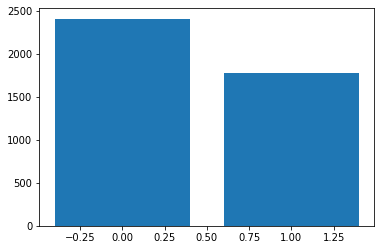

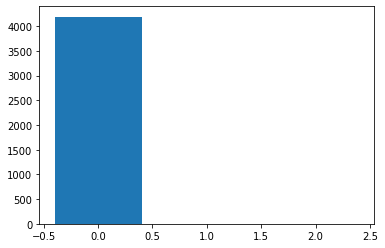

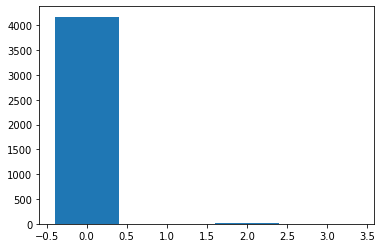

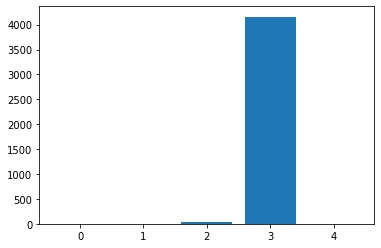

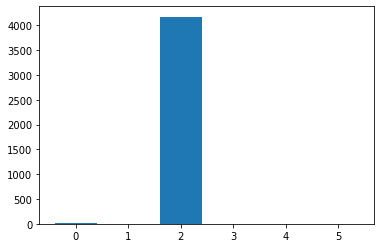

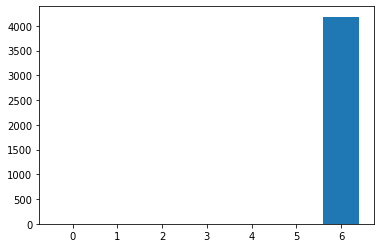

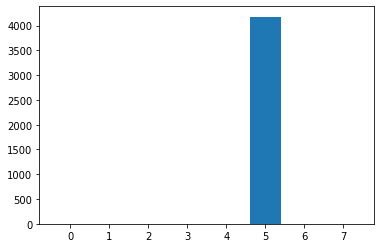

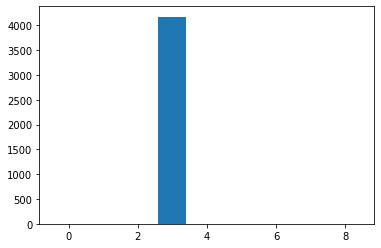

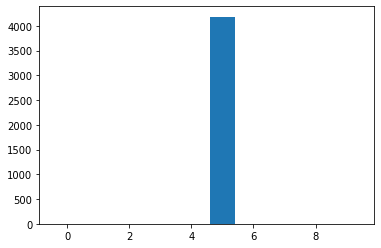

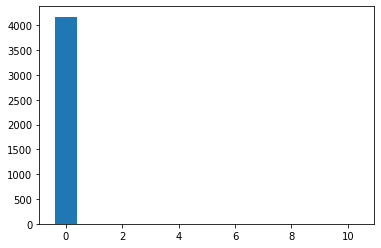

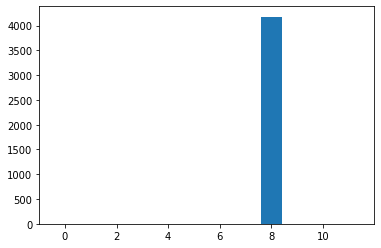

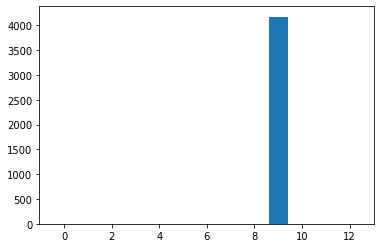

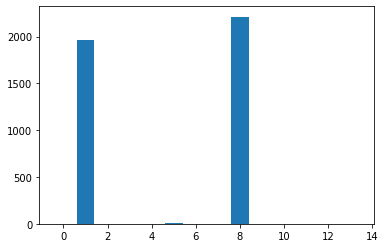

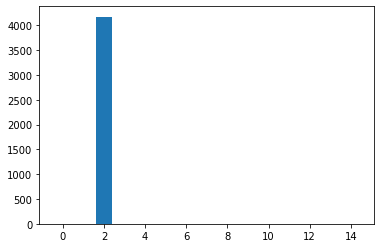

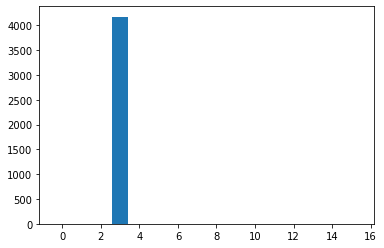

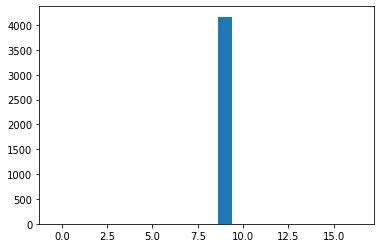

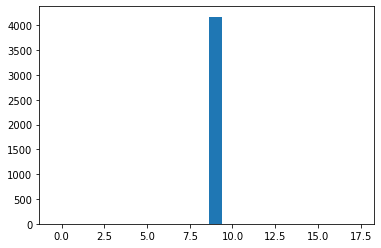

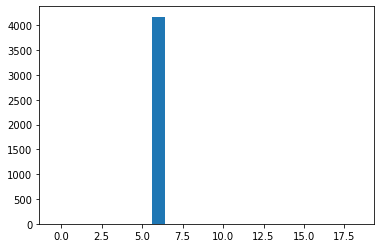

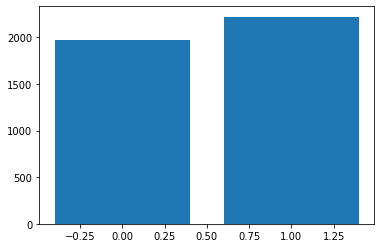

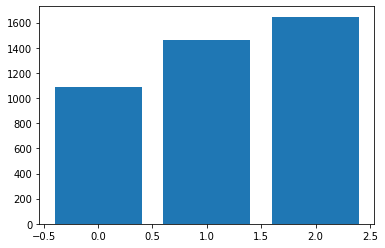

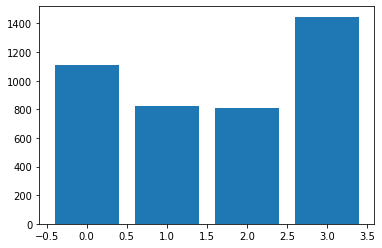

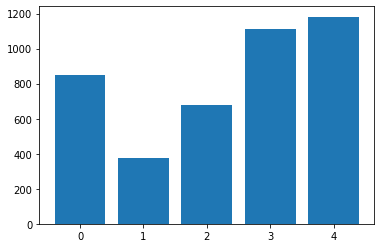

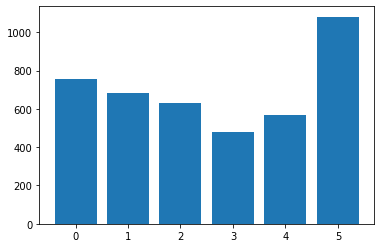

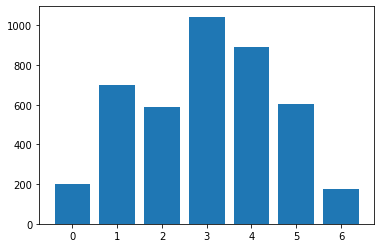

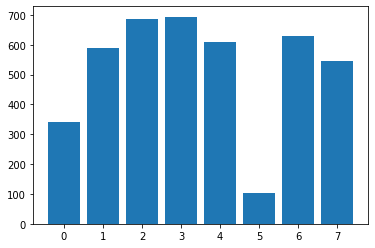

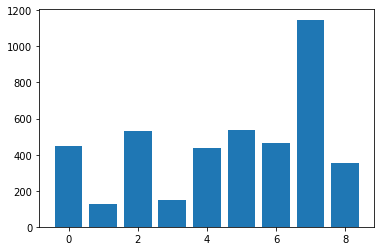

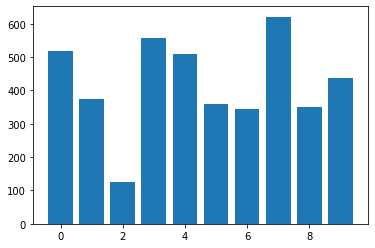

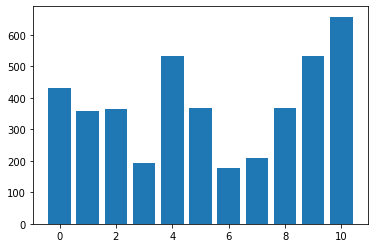

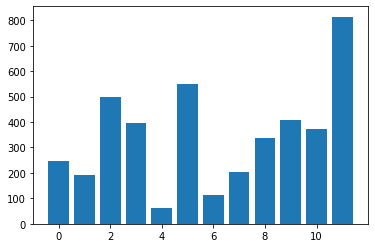

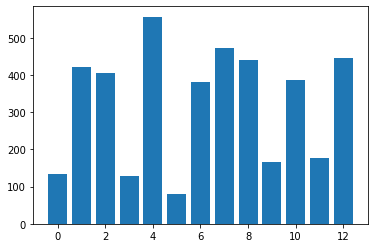

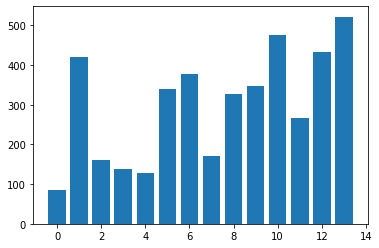

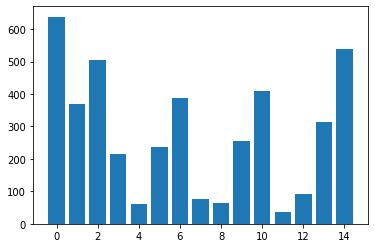

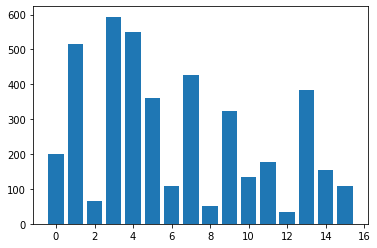

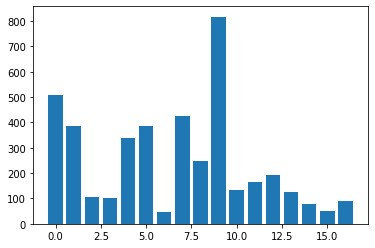

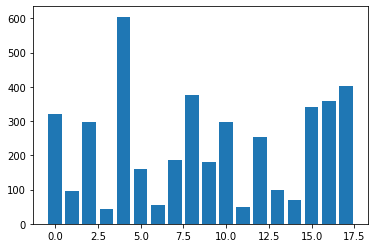

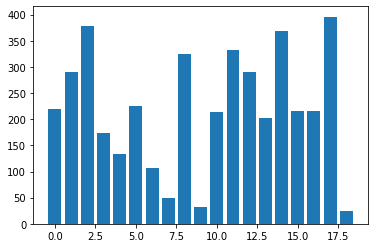

In [18]:
# Selecting the vectorizer
bow = CountVectorizer(lowercase = True,tokenizer=tokenize, max_features = 5000)
tfidf = TfidfVectorizer(analyzer = 'word',tokenizer = tokenize, lowercase = True, max_features = 5000)

vectorizers = [tfidf, bow]
                
# Selecting number of topics
number_of_topics = list(range(2,20))
                        
# Selecting the k nearest
k_nearest = [3,5,10]


for v in vectorizers:
    path_string ='./results/'
    #print()
    if type(v)==TfidfVectorizer:
        path_string+='tfidf/'
    else:
        path_string+='bow/'
        
    print('Vectorizing ...')
    feature_matrix = v.fit_transform(train_df['summary_no_names'])
    test_feature_matrix = v.transform(test_df['summary_no_names']).toarray()
    # baseline
    baseline_path = path_string+'baseline.txt'
    print('baseline',baseline_path )
    baseline_file = open(baseline_path, 'w+', encoding = 'utf-8')
    baseline_file.write('BASELINE FILE \n')
    baseline_evaluation_measure = []
    for i,movie in tqdm(test_df.iterrows()):
        baseline_file.write('***************\n')
        baseline_file.write('MOVIE :'+movie['movie_id']+'\n')
        baseline_pred_actors = retrieve_cast(cast,baseline(feature_matrix, test_feature_matrix[i]))
        baseline_label_actors = retrieve_cast(test_cast, [i])
        baseline_evaluation_measure += evaluate_movie_suggestion(baseline_pred_actors, baseline_label_actors)
        b = log_actors(baseline_pred_actors)
        baseline_file.write('Evaluation: \n')
        baseline_file.write('m20 : '+ str(baseline_evaluation_measure[-3])+ "\n")
        baseline_file.write('m50 : '+ str(baseline_evaluation_measure[-2])+ "\n")
        baseline_file.write('m100 : '+ str(baseline_evaluation_measure[-1])+ "\n")
        baseline_file.writelines(b)
        
    baseline_file.close()
    baseline_evaluation_file = open(path_string+'baseline_evaluation.txt', 'w+')
    write_evaluation_file(baseline_evaluation_file, baseline_evaluation_measure)
    baseline_evaluation_file.close()
    
    for t in number_of_topics:
        experiment_path=path_string+"topic"+str(t)+"/"
        if not os.path.exists(experiment_path):
            os.mkdir(experiment_path)
            
        lda = LatentDirichletAllocation(n_components = t)
        print('lda training ..', t)
        document_topics = lda.fit_transform(feature_matrix)
        feature_names = np.array(v.get_feature_names())
        
        clusters =  np.argmax(document_topics, axis=1)
        train_df['clusters'] = clusters
        cluster_counts = [0 for _ in range(t)]
        for c in clusters:
            cluster_counts[c]+=1
        
        plt.figure()
        plt.bar(range(t), cluster_counts)
        plt.savefig(experiment_path+'cluster_distribution.png')
        
        t_report_file = open(experiment_path+'topic_report.txt','w+', encoding = 'utf-8')
        topic_report(t_report_file, train_df, t, np.array(v.get_feature_names()), np.argsort(lda.components_, axis=1)[:, ::-1])
        t_report_file.close()
        
        word_cloud_path = experiment_path+'wordclouds/'
        print('word cloud')
        if not os.path.exists(word_cloud_path):
            os.mkdir(word_cloud_path)
            
        for w in range(t):
            word_cloud = topic_word_cloud(lda, feature_names, w)
            word_cloud.to_file(word_cloud_path+str(w)+'.png')
        
        print('experimenting')
        for k in k_nearest:
            experiment_file_name =experiment_path+'k_'+str(k)+'.txt'
            experiment_file = open(experiment_file_name, 'w+', encoding = 'utf-8')
            experiment_file.write('Experiment \n')
            experiment_file.write("## METADATA ## \n")
            experiment_file.write("Vectorizer :"+ str(v)+'\n')
            experiment_file.write("N_topics :"+ str(t)+'\n')
            experiment_file.write("K_nearest :"+ str(k)+'\n')
            experiment_file.write("##############")
            
            experiment_evaluation_measure = []
            for i,movie in tqdm(test_df.iterrows()):
                experiment_file.write('***********************\n')
                experiment_file.write('MOVIE :'+ movie['movie_id']+'\n')
                experiment_pred_actors = retrieve_cast(cast,get_list_of_k_nearest_documents(lda,document_topics, np.array([test_feature_matrix[i]]), k = k))
                experiment_label_actors = retrieve_cast(test_cast, [i])
                experiment_evaluation_measure += evaluate_movie_suggestion(experiment_pred_actors, experiment_label_actors)
                experiment_file.write('Evaluation: \n')
                experiment_file.write('m20 : '+ str(baseline_evaluation_measure[-3])+ "\n")
                experiment_file.write('m50 : '+ str(baseline_evaluation_measure[-2])+ "\n")
                experiment_file.write('m100 : '+ str(baseline_evaluation_measure[-1])+ "\n")
                b = log_actors(experiment_pred_actors)
                experiment_file.writelines(b)
            
            experiment_file.close()
            experiment_evaluation_file = open(experiment_path + 'k_'+ str(k)+ '_evaluation.txt', 'w+')
            write_evaluation_file(experiment_evaluation_file, experiment_evaluation_measure)
            experiment_evaluation_file.close()
        
        experiment_file_name = experiment_path+'cluster.txt'
        experiment_file = open(experiment_file_name, 'w+', encoding = 'utf-8')
        experiment_file.write('Experiment cluster \n')
        experiment_evaluation_measure = []
        for i,movie in tqdm(test_df.iterrows()):
            experiment_file.write('***********************\n')
            experiment_file.write('MOVIE :'+ movie['movie_id']+'\n')
            cl, doc_index = get_list_of_actors_clustering(lda, document_topics, np.array([test_feature_matrix[i]]))
            experiment_file.write('CLUSTER :' +str(cl)+'\n')
            experiment_pred_actors = retrieve_cast(cast,doc_index)
            experiment_label_actors = retrieve_cast(test_cast, [i])
            experiment_evaluation_measure += evaluate_movie_suggestion(experiment_pred_actors, experiment_label_actors)
            b = log_actors(experiment_pred_actors)
            experiment_file.write('Evaluation: \n')
            experiment_file.write('m20 : '+ str(baseline_evaluation_measure[-3])+ "\n")
            experiment_file.write('m50 : '+ str(baseline_evaluation_measure[-2])+ "\n")
            experiment_file.write('m100 : '+ str(baseline_evaluation_measure[-1])+ "\n")
            
            experiment_file.writelines(b)
        
        experiment_file.close()
        experiment_evaluation_file = open(experiment_path + 'cluster_evaluation.txt', 'w+')
        write_evaluation_file(experiment_evaluation_file, experiment_evaluation_measure)
        experiment_evaluation_file.close()
        
            